## Imports and Setup

In [1]:
# Standard imports
import os, sys
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import hvplot.xarray  
import geoviews as gv
import holoviews as hv
import pandas as pd
import panel as pn
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output
import dask

# Panel/HoloViews setup
pn.extension()
gv.extension('bokeh')

# Add scripts to path
sys.path.append(os.path.realpath('../scripts/'))
from netcdf_utils import quick_download
from pimep_config import PIMEPConfig

config = PIMEPConfig()

## Configuration Classes

In [2]:
class DatasetConfig:
    """Configuration class for Triple Collocation."""
    
    SATELLITE_DATASETS = {
        'smos': [
            {'id': 'smos-l3-catds-cpdc-v335-1m-25km', 'name': 'SMOS SSS L3 v335 - Monthly - 25 km (CATDS-CPDC)', 'resolution': '25km', 'frequency': 'monthly'},
            {'id': 'smos-l3-catds-cpdc-v332-9d-resample-1m', 'name': 'SMOS SSS L3 v332 - 9 Days (CATDS-CPDC)', 'resolution': '25km', 'frequency': '9-day'},
            {'id': 'smos-l3-catds-locean-v9-9d-resample-1m', 'name': 'SMOS SSS L3 v9 - 9 Days (CATDS-CEC-LOCEAN)', 'resolution': '25km', 'frequency': '9-day'},
            {'id': 'smos-l3-catds-locean-v10-9d-resample-1m', 'name': 'SMOS SSS L3 v10 - 9 Days (CATDS-CEC-LOCEAN)', 'resolution': '25km', 'frequency': '9-day'}
        ],
        'smap': [
            {'id': 'smap-l3-rss-v6-1m', 'name': 'SMAP SSS L3 v6 - Monthly (RSS)', 'resolution': '0.25 degree', 'frequency': 'monthly'},
            {'id': 'smap-l3-jpl-v5.0-1m', 'name': 'SMAP SSS L3 v5.0 - Monthly (JPL)', 'resolution': '0.25 degree', 'frequency': 'monthly'}
        ]
    }
    
    INSITU_DATASETS = [
        {'id': 'metof', 'name': 'EN4 - 5m', 'depth': '5m', 'source': 'Met Office'},
        {'id': 'isas', 'name': 'ISAS - 5m', 'depth': '5m', 'source': 'ISAS'},
        {'id': 'scripps', 'name': 'Scripps - 2.5m', 'depth': '2.5m', 'source': 'Scripps'}
    ]
    
    REGIONS = [
        {'id': 'GO', 'name': 'Global Ocean', 'lat_min': -90, 'lat_max': 90, 'lon_min': -180, 'lon_max': 180},
        {'id': 'OTT', 'name': 'OTT region', 'lat_min': -45, 'lat_max': -5, 'lon_min': -140, 'lon_max': -95}
    ]
    
    METHODS = [
        {'id': 'TC', 'name': 'Triple Collocation'},
        {'id': 'CTC', 'name': 'Correlated Triple Collocation'}
    ]
    
    @classmethod
    def get_all_satellite_options(cls):
        all_datasets = []
        for datasets in cls.SATELLITE_DATASETS.values():
            all_datasets.extend(datasets)
        return all_datasets
    
    @classmethod
    def get_satellite_options_by_priority(cls):
        return cls.SATELLITE_DATASETS['smap'] + cls.SATELLITE_DATASETS['smos']
    
    @classmethod
    def get_dataset_by_id(cls, dataset_id):
        for datasets in cls.SATELLITE_DATASETS.values():
            for dataset in datasets:
                if dataset['id'] == dataset_id:
                    return dataset
        for dataset in cls.INSITU_DATASETS + cls.REGIONS + cls.METHODS:
            if dataset['id'] == dataset_id:
                return dataset
        return None
    
    @classmethod
    def get_region_bounds(cls, region_id):
        region = cls.get_dataset_by_id(region_id)
        if region and 'lat_min' in region:
            return {k: region[k] for k in ['lat_min', 'lat_max', 'lon_min', 'lon_max']}
        return None

## Widget Interface

In [3]:
class TripleCollocationInterface:
    """Interactive interface for Triple Collocation analysis."""
    
    def __init__(self):
        self.config = DatasetConfig()
        self.widgets = self._create_widgets()
        self.data = None
        self.metadata = None
        
    def _create_widgets(self):
        """Create all widgets."""
        style = {'description_width': '150px'}
        layout = widgets.Layout(width='600px')
        
        # Create options
        sat_options = [(d['name'], d['id']) for d in self.config.get_all_satellite_options()]
        sat_priority_options = [(d['name'], d['id']) for d in self.config.get_satellite_options_by_priority()]
        insitu_options = [(d['name'], d['id']) for d in self.config.INSITU_DATASETS]
        region_options = [(r['name'], r['id']) for r in self.config.REGIONS]
        method_options = [(r['name'], r['id']) for r in self.config.METHODS]
        
        widgets_dict = {
            'method': widgets.Dropdown(options=method_options, description='Method:', value=method_options[0][1], style=style, layout=layout),
            'region': widgets.Dropdown(options=region_options, description='Region:', value=region_options[0][1], style=style, layout=layout),
            'satellite_1': widgets.Dropdown(options=sat_options, description='Primary Satellite:', value=sat_options[0][1], style=style, layout=layout),
            'satellite_2': widgets.Dropdown(options=sat_priority_options, description='Secondary Satellite:', value=sat_priority_options[1][1] if len(sat_priority_options) > 1 else None, style=style, layout=layout),
            'insitu': widgets.Dropdown(options=insitu_options, description='In-situ Dataset:', value=insitu_options[0][1], style=style, layout=layout)
        }
        
        # Add load button and output area
        widgets_dict['load_button'] = widgets.Button(description='Load Data', button_style='primary', layout=widgets.Layout(width='200px'))
        widgets_dict['output'] = widgets.Output()
        
        # Connect button to load function
        widgets_dict['load_button'].on_click(self._on_load_clicked)
        
        return widgets_dict
    
    def _on_load_clicked(self, button):
        """Handle load button click."""
        with self.widgets['output']:
            clear_output()
            self.load_data()
    
    def display(self):
        """Display the interface."""
        title = widgets.HTML("<h3>Triple Collocation Analysis</h3>", layout={'margin': '10px 0px'})
        
        controls = widgets.VBox([
            title,
            self.widgets['method'],
            self.widgets['region'],
            self.widgets['satellite_1'],
            self.widgets['satellite_2'],
            self.widgets['insitu'],
            self.widgets['load_button']
        ], layout={'padding': '15px'})
        
        interface = widgets.VBox([controls, self.widgets['output']])
        display(interface)
    
    def load_data(self):
        """Load both temporal and spatial data based on current selections."""
        try:
            # Get selections
            selections = {name: widget.value for name, widget in self.widgets.items() 
                         if name not in ['load_button', 'output']}
            
            # Get metadata
            metadata = {}
            for key, value in selections.items():
                info = self.config.get_dataset_by_id(value)
                metadata[key] = {
                    'id': value,
                    'name': info['name'] if info else 'Unknown',
                    'info': info
                }
            
            # Display selections
            print("📊 Current Selections:")
            print("-" * 50)
            for key, meta in metadata.items():
                print(f"{key.replace('_', ' ').title()}: {meta['name']}")
            print()
            
            # Build file paths
            method, region, sat1, sat2, insitu = [selections[k] for k in 
                                                ['method', 'region', 'satellite_1', 'satellite_2', 'insitu']]
            
            data_path = Path('../data/triple-collocation')
            data_path.mkdir(parents=True, exist_ok=True)
            
            base_dir = data_path / method / region / sat1 / sat2 / insitu / 'ncfile'
            
            # Define both files to download
            temporal_filename = f'pimep-{method.lower()}-ncfile_temporal_{sat1}_{sat2}_{insitu}.nc'
            spatial_filename = f'pimep-{method.lower()}-ncfile_spatial_{sat1}_{sat2}_{insitu}.nc'
            
            temporal_path = base_dir / temporal_filename
            spatial_path = base_dir / spatial_filename
            
            # Ensure the directory exists
            base_dir.mkdir(parents=True, exist_ok=True)
            
            # Load or download temporal data
            print("🕒 Loading Temporal Data...")
            if temporal_path.exists():
                print(f"✅ Loading temporal data from existing file...")
                temporal_data = xr.open_mfdataset(temporal_path, decode_timedelta=False)
                print(f"✅ Temporal data loaded successfully!")
            else:
                print(f"📥 Temporal file not found locally. Attempting to download...")
                try:
                    url_pimep_web = 'https://pimep.ifremer.fr/diffusion/'
                    relative_path = temporal_path.relative_to(data_path)
                    download_url = f"{url_pimep_web}analyses/triple-collocation/{relative_path}"
                    print(f"Download URL: {download_url}")
                    
                    temporal_data = quick_download(download_url, base_dir, use_wget=False)
                    print(f"✅ Temporal data downloaded and loaded successfully!")
                except Exception as e:
                    print(f"❌ Failed to download temporal data: {e}")
                    temporal_data = None
            
            # Load or download spatial data
            print("\n🗺️ Loading Spatial Data...")
            if spatial_path.exists():
                print(f"✅ Loading spatial data from existing file...")
                spatial_data = xr.open_mfdataset(spatial_path, decode_timedelta=False)
                print(f"✅ Spatial data loaded successfully!")
            else:
                print(f"📥 Spatial file not found locally. Attempting to download...")
                try:
                    url_pimep_web = 'https://pimep.ifremer.fr/diffusion/'
                    relative_path = spatial_path.relative_to(data_path)
                    download_url = f"{url_pimep_web}analyses/triple-collocation/{relative_path}"
                    print(f"Download URL: {download_url}")
                    
                    spatial_data = quick_download(download_url, base_dir, use_wget=False)
                    print(f"✅ Spatial data downloaded and loaded successfully!")
                except Exception as e:
                    print(f"❌ Failed to download spatial data: {e}")
                    spatial_data = None
            
            # Store the datasets
            self.temporal_data = temporal_data
            self.spatial_data = spatial_data
            
            # Store metadata
            self.metadata = metadata
            self.metadata['bounds'] = self.config.get_region_bounds(region)
            
            # Display data info
            print(f"\n📈 Dataset Information:")
            if temporal_data is not None:
                print(f"Temporal data:")
                print(f"  Dimensions: {dict(temporal_data.dims)}")
                print(f"  Variables: {list(temporal_data.data_vars)}")
            
            if spatial_data is not None:
                print(f"Spatial data:")
                print(f"  Dimensions: {dict(spatial_data.dims)}")
                print(f"  Variables: {list(spatial_data.data_vars)}")
            
            if temporal_data is None and spatial_data is None:
                print("❌ No data files were successfully loaded.")
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
    
    def get_temporal_data(self):
        """Get the temporal dataset."""
        return getattr(self, 'temporal_data', None)
    
    def get_spatial_data(self):
        """Get the spatial dataset."""
        return getattr(self, 'spatial_data', None)
    
    def get_data(self, data_type=None):
        """Get the loaded dataset(s).
        
        Args:
            data_type (str, optional): 'temporal' or 'spatial'. If None, returns both as dict.
        """
        if data_type == 'temporal':
            return self.get_temporal_data()
        elif data_type == 'spatial':
            return self.get_spatial_data()
        else:
            # Return both as dictionary
            temporal = self.get_temporal_data()
            spatial = self.get_spatial_data()
            result = {}
            if temporal is not None:
                result['temporal'] = temporal
            if spatial is not None:
                result['spatial'] = spatial
            return result if result else None
    
    def get_metadata(self):
        """Get metadata about selections."""
        return self.metadata
    
    def plot_summary(self):
        """Create summary plots of the loaded data."""
        temporal_data = self.get_temporal_data()
        spatial_data = self.get_spatial_data()
        
        if temporal_data is None and spatial_data is None:
            print("❌ No data loaded. Please load data first.")
            return
        
        print("🎨 Creating summary plots...")
        
        # Determine number of plots needed
        n_plots = sum([temporal_data is not None, spatial_data is not None])
        fig, axes = plt.subplots(n_plots, 2, figsize=(15, 6*n_plots))
        if n_plots == 1:
            axes = axes.reshape(1, -1)
        
        plot_idx = 0
        
        # Plot temporal data
        if temporal_data is not None:
            # Time series plot
            ax1 = axes[plot_idx, 0] if n_plots > 1 else axes[0]
            ax1.set_title('Temporal Data - Time Series')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Value')
            
            # Spatial distribution from temporal data
            ax2 = axes[plot_idx, 1] if n_plots > 1 else axes[1]
            ax2.set_title('Temporal Data - Spatial Distribution')
            ax2.set_xlabel('Longitude')
            ax2.set_ylabel('Latitude')
            
            plot_idx += 1
        
        # Plot spatial data
        if spatial_data is not None:
            ax1 = axes[plot_idx, 0] if n_plots > 1 else axes[0]
            ax1.set_title('Spatial Data - Distribution')
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')
            
            ax2 = axes[plot_idx, 1] if n_plots > 1 else axes[1]
            ax2.set_title('Spatial Data - Statistics')
            ax2.set_xlabel('Variable')
            ax2.set_ylabel('Value')
        
        plt.tight_layout()
        plt.show()

## Create and Display Interface

In [ ]:
# Create the interface
tc_interface = TripleCollocationInterface()
tc_interface.display()

In [5]:
temporal_data = tc_interface.get_temporal_data()
spatial_data  = tc_interface.get_spatial_data()


In [9]:
sat1 = tc_interface.widgets['satellite_1'].value
sat2 = tc_interface.widgets['satellite_2'].value
method = tc_interface.widgets['method'].value
region = tc_interface.widgets['region'].value
insitu = tc_interface.widgets['insitu'].value

sat1_name = tc_interface.widgets['satellite_1'].label
sat2_name = tc_interface.widgets['satellite_2'].label
method_name = tc_interface.widgets['method'].label
region_name = tc_interface.widgets['region'].label
insitu_name = tc_interface.widgets['insitu'].label

## Maps of RMSE, SNR, SENSITIVITY and Correlation

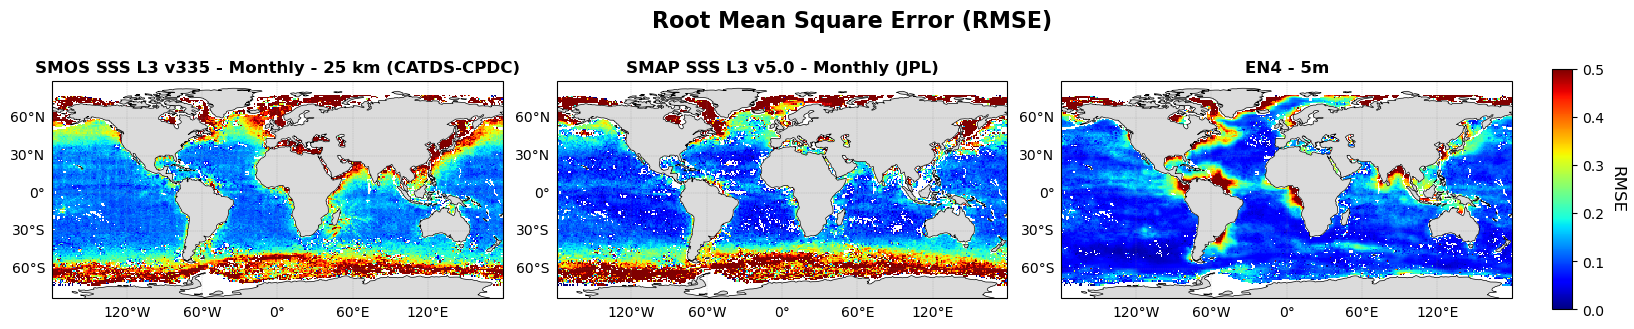

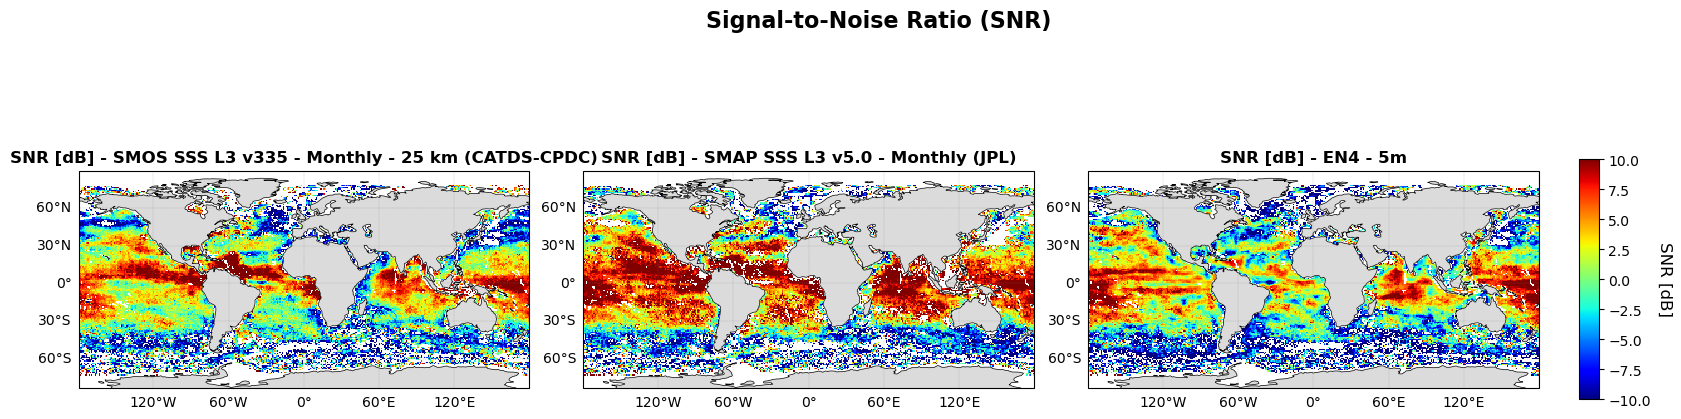

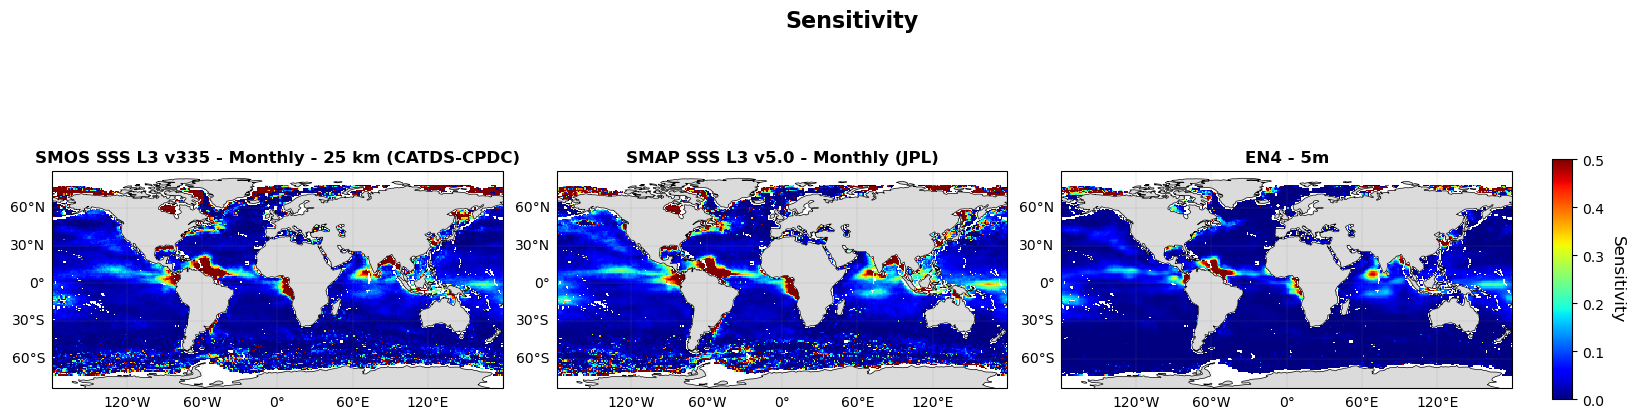

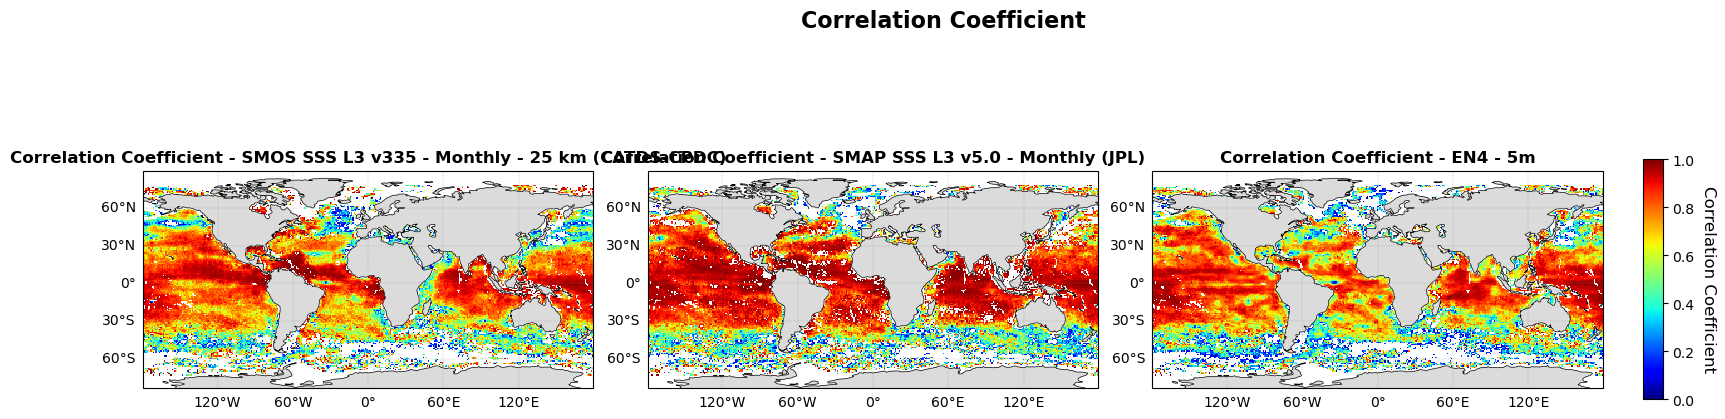

In [ ]:
# Set up projection and map features
projection = ccrs.PlateCarree()
map_features = {
    'land': cfeature.LAND.with_scale('50m'),
    'ocean': cfeature.OCEAN.with_scale('50m'),
    'coastline': cfeature.COASTLINE.with_scale('50m'),
    'borders': cfeature.BORDERS.with_scale('50m'),
    'rivers': cfeature.RIVERS.with_scale('50m'),
    'lakes': cfeature.LAKES.with_scale('50m')
}

def add_map_features(ax, add_gridlines=True):
    """Add standard map features to a cartopy axis."""
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.8)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
    
    if add_gridlines:
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

# Plot RMSE maps
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': projection})

# RMSE plots
im1 = spatial_data.stderr.sel(product=sat1).plot(
    ax=axs[0], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[0])
axs[0].set_title(f'{sat1_name}', fontsize=12, fontweight='bold')

im2 = spatial_data.stderr.sel(product=sat2).plot(
    ax=axs[1], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[1])
axs[1].set_title(f'{sat2_name}', fontsize=12, fontweight='bold')

im3 = spatial_data.stderr.sel(product=insitu).plot(
    ax=axs[2], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[2])
axs[2].set_title(f'{insitu_name}', fontsize=12, fontweight='bold')

# Add a single colorbar for all RMSE plots
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83, wspace=0.12, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('RMSE', rotation=270, labelpad=15, fontsize=12)

plt.suptitle('Root Mean Square Error (RMSE)', fontsize=16, fontweight='bold', y=0.80)
plt.show()

# Plot SNR maps
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': projection})

im1 = spatial_data.snr_db.sel(product=sat1).plot(
    ax=axs[0], cmap='jet', vmin=-10, vmax=10, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[0])
axs[0].set_title(f'SNR [dB] - {sat1_name}', fontsize=12, fontweight='bold')

im2 = spatial_data.snr_db.sel(product=sat2).plot(
    ax=axs[1], cmap='jet', vmin=-10, vmax=10, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[1])
axs[1].set_title(f'SNR [dB] - {sat2_name}', fontsize=12, fontweight='bold')

im3 = spatial_data.snr_db.sel(product=insitu).plot(
    ax=axs[2], cmap='jet', vmin=-10, vmax=10, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[2])
axs[2].set_title(f'SNR [dB] - {insitu_name}', fontsize=12, fontweight='bold')

# Add colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83, wspace=0.12, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('SNR [dB]', rotation=270, labelpad=15, fontsize=12)

plt.suptitle('Signal-to-Noise Ratio (SNR)', fontsize=16, fontweight='bold', y=0.8)
plt.show()

# Plot Sensitivity maps
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': projection})

im1 = spatial_data.sensitivity.sel(product=sat1).plot(
    ax=axs[0], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[0])
axs[0].set_title(f'{sat1_name}', fontsize=12, fontweight='bold')

im2 = spatial_data.sensitivity.sel(product=sat2).plot(
    ax=axs[1], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[1])
axs[1].set_title(f'{sat2_name}', fontsize=12, fontweight='bold')

im3 = spatial_data.sensitivity.sel(product=insitu).plot(
    ax=axs[2], cmap='jet', vmin=0, vmax=0.5, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[2])
axs[2].set_title(f'{insitu_name}', fontsize=12, fontweight='bold')

# Add colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83, wspace=0.12, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('Sensitivity', rotation=270, labelpad=15, fontsize=12)

plt.suptitle('Sensitivity', fontsize=16, fontweight='bold', y=0.8)
plt.show()

# Plot Correlation Coefficients maps
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': projection})

im1 = spatial_data.rho.sel(product=sat1).plot(
    ax=axs[0], cmap='jet', vmin=0, vmax=1, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[0])
axs[0].set_title(f'{sat1_name}', fontsize=12, fontweight='bold')

im2 = spatial_data.rho.sel(product=sat2).plot(
    ax=axs[1], cmap='jet', vmin=0, vmax=1, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[1])
axs[1].set_title(f'{sat2_name}', fontsize=12, fontweight='bold')

im3 = spatial_data.rho.sel(product=insitu).plot(
    ax=axs[2], cmap='jet', vmin=0, vmax=1, 
    transform=ccrs.PlateCarree(), add_colorbar=False
)
add_map_features(axs[2])
axs[2].set_title(f'{insitu_name}', fontsize=12, fontweight='bold')

# Add colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83, wspace=0.12, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15, fontsize=12)

plt.suptitle('Correlation Coefficient', fontsize=16, fontweight='bold', y=0.95)
plt.show()

# Optional: Create a single combined plot for comparison
def create_combined_plot(data, variable, titles, vmin, vmax, cmap='jet', unit=''):
    """Create a combined plot for easy comparison."""
    fig, axs = plt.subplots(2, 3, figsize=(24, 12), subplot_kw={'projection': projection})
    
    products = [sat1, sat2, insitu]
    
    for i, (product, title) in enumerate(zip(products, titles)):
        row = i // 3
        col = i % 3
        
        im = data.sel(product=product).plot(
            ax=axs[row, col] if len(products) > 3 else axs[col], 
            cmap=cmap, vmin=vmin, vmax=vmax,
            transform=ccrs.PlateCarree(), add_colorbar=False
        )
        add_map_features(axs[row, col] if len(products) > 3 else axs[col])
        (axs[row, col] if len(products) > 3 else axs[col]).set_title(
            f'{variable} - {title}', fontsize=14, fontweight='bold'
        )
    
    # Hide empty subplots if any
    if len(products) < 6:
        for i in range(len(products), 6):
            row = i // 3
            col = i % 3
            axs[row, col].set_visible(False)
    
    # Add colorbar
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.85, wspace=0.05, hspace=0.1)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(f'{variable} {unit}', rotation=270, labelpad=20, fontsize=14)
    
    plt.suptitle(f'{variable} Comparison Maps', fontsize=18, fontweight='bold', y=0.95)
    plt.show()

# Example usage of combined plot function:
# create_combined_plot(
#     spatial_data.stderr, 
#     'RMSE', 
#     [sat1_name, sat2_name, insitu_name], 
#     0, 0.5, 'jet', ''
# )
